# Определение возраста покупателей

В проекте необходимо рассмотреть датасет, оценить достаточность его объема и качества для обучения модели. Так как данные содержат всего 2 параметра: фото и возраст, стоит так же оценить взвешенность данных. По итогам проекта нужно обучить модель, способную предсказывать возраст и соотнести результат с исходными тезисами.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## Исследовательский анализ данных

In [ ]:
# < Перенесите сюда исследовательский анализ данных >
df = pd.read_csv("/datasets/faces/labels.csv")
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000



В выборке всего 7591 пример, из них неизвестно, сколько процентов подходит для обучения. Для обучения сверточной и тем более полносвязной сети с нуля этого точно недостаточно в рамках разумного времени, поэтому логично использовать предобученную архитектуру и дообучить только последний слой регрессор. 


In [ ]:
df.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

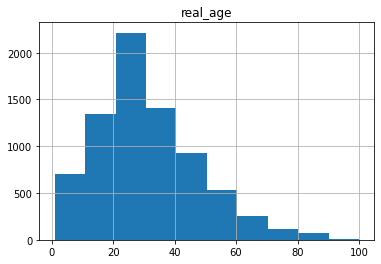

In [ ]:
df.hist()

Наибольшая группа покупателей от 20 до 30тлет, достаточно много детей. А вот людей старше 80 очень мало

№ 16 Возраст 24


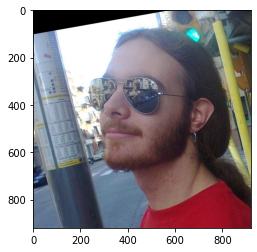

№ 17 Возраст 5


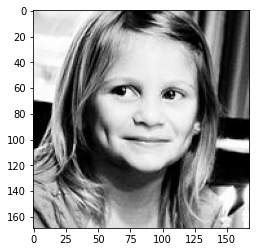

№ 18 Возраст 40


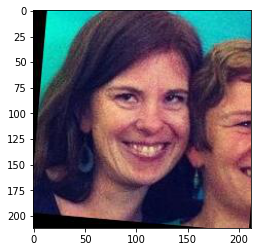

№ 19 Возраст 16


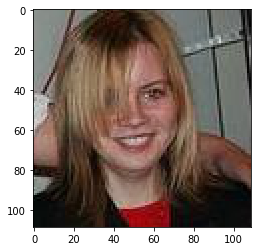

№ 20 Возраст 29


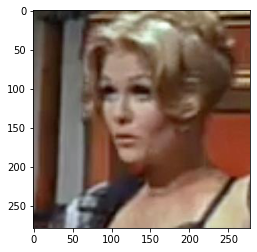

№ 21 Возраст 1


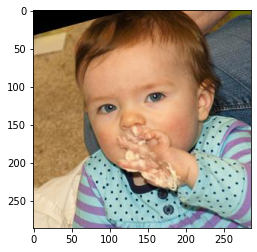

№ 22 Возраст 35


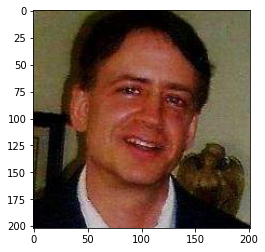

№ 23 Возраст 25


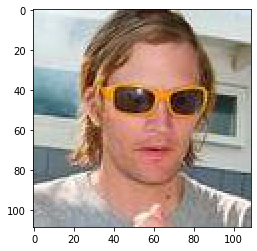

№ 24 Возраст 5


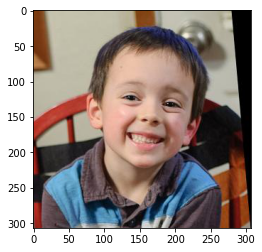

№ 25 Возраст 30


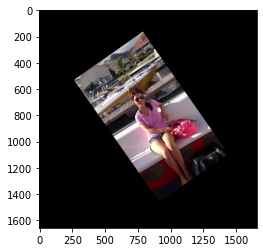

№ 26 Возраст 24


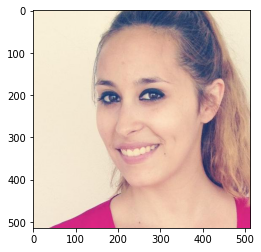

№ 27 Возраст 35


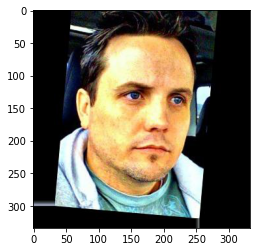

№ 28 Возраст 65


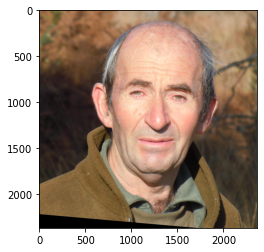

№ 29 Возраст 13


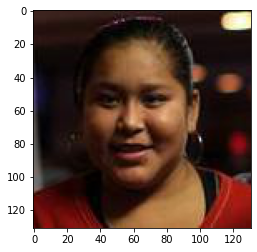

№ 30 Возраст 1


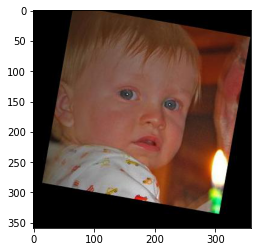

№ 31 Возраст 28


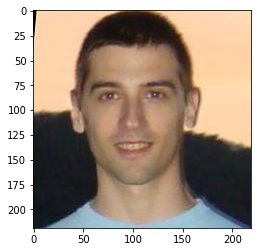

№ 32 Возраст 27


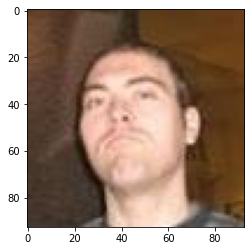

№ 33 Возраст 16


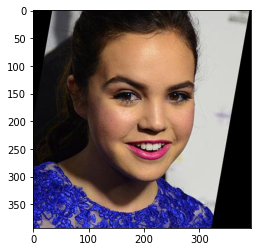

№ 34 Возраст 4


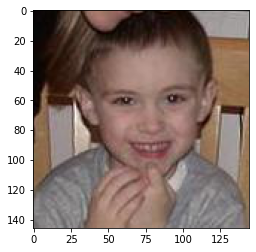

№ 35 Возраст 16


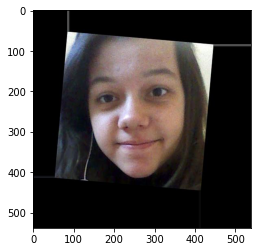

№ 36 Возраст 2


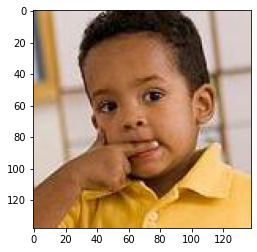

№ 37 Возраст 31


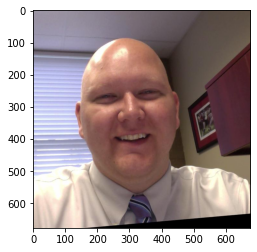

№ 38 Возраст 10


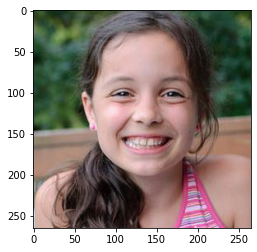

№ 39 Возраст 4


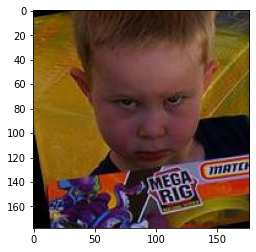

№ 40 Возраст 1


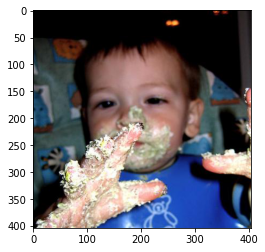

№ 41 Возраст 34


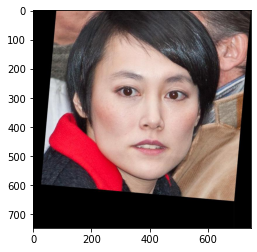

№ 42 Возраст 15


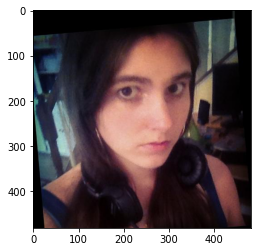

№ 43 Возраст 30


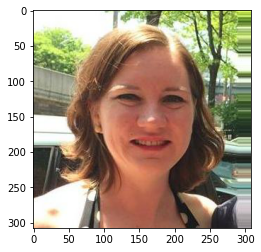

№ 44 Возраст 8


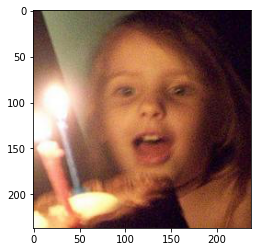

№ 45 Возраст 20


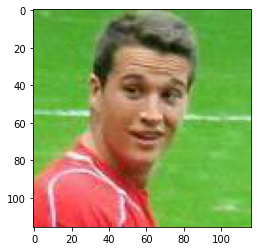

№ 46 Возраст 16


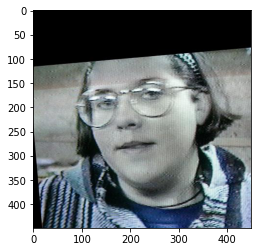

№ 47 Возраст 19


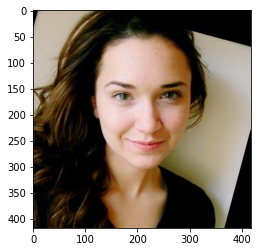

№ 48 Возраст 40


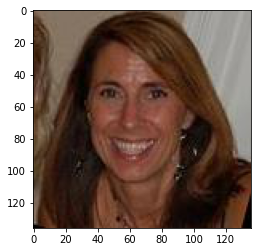

№ 49 Возраст 10


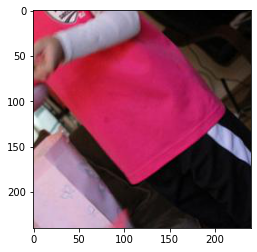

(240, 240, 3)


In [ ]:
for i in range(16, 50):
    image = Image.open('/datasets/faces/final_files/'+df.file_name[i])
    print("№", i, "Возраст", df.real_age[i])
    plt.imshow(np.array(image))
    plt.show()

print(np.array(image).shape)


    
1. Выборка сильно смещена в сторону более молодых лиц 20-25 лет. Возраст для более возрастных и более молодых лиц будет предсказываться хуже
    
2. фото взяты из разнообразных локаций, что может затруднить задачу, при работе в "полевых" условиях
    
3. Фотографии в целом центрированы по лицу, каких-то дополнительных поворотов головы не требуется. Иногда встречаются неправильно повернутые фотографии, вроде 30 из-за маленького размера лица. Таких примеров субъективно немного, в рамках этой работы можно игнорировать. На практике такие примеры стоит или до размечать, или выкинуть.
    
4. Размер изображений сильно разнится от фото к фото, нужно приводить к единому разрешению.
    
5. Иногда встречаются черно белые фотографии или фотографии, раскрашенные вручную. 
    
6. Также стоит обратить внимание на мусор, вроде 50 фотографии (ниже). К сожалению в рамках этой работы автоматическими методами подчистить это будет сложно, поэтому оставляю без изменений. На практике надо чистить


Возраст 10


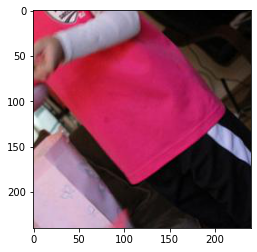

In [ ]:
image = Image.open('/datasets/faces/final_files/'+df.file_name[49])
print("Возраст", df.real_age[49])
plt.imshow(np.array(image))
plt.show()

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import pandas as pd

def load_train(path):
    df = pd.read_csv(path + '/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale          = 1./255,
        validation_split = .25,
        horizontal_flip  = True
        )
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe   = df, 
        directory   = path + "/final_files/", 
        x_col       = "file_name", 
        y_col       = "real_age", 
        class_mode  = "raw", 
        subset      = 'training', 
        target_size = (224, 224), 
        batch_size  = 16,
        seed        = 12345
        ) 

    return train_generator

def load_test(path):
    df = pd.read_csv(path + '/labels.csv')

    test_datagen = ImageDataGenerator(
        rescale          = 1./255,
        validation_split = 0.25,
        )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe   = df, 
        directory   = path + "/final_files/", 
        x_col       = "file_name", 
        y_col       = "real_age", 
        class_mode  = "raw", 
        subset      = 'validation', 
        target_size = (224, 224), 
        batch_size  = 16,
        seed        = 12345
        ) 

    return test_generator

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
        )
    # замораживаем ResNet50 без верхушки
#     backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0008)

    model.compile(
        optimizer=optimizer, 
        loss='mean_squared_error', 
        metrics=['mae']) 

    return model
    
def train_model(
        model, 
        train_data, 
        test_data, 
        batch_size       = None, 
        epochs           = 20, 
        steps_per_epoch  = None, 
        validation_steps = None
        ):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
            validation_steps = len(test_data)
            
    model.fit(
        train_data,
        validation_data  = test_data,
        batch_size       = batch_size, 
        epochs           = epochs,
        steps_per_epoch  = steps_per_epoch,
        validation_steps = validation_steps,
        verbose          = 2,
        shuffle          = True   
        )
    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Found 5694 validated image filenames.
Found 1897 validated image filenames.


Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 49s - loss: 277.2339 - mae: 12.6358 - val_loss: 313.3071 - val_mae: 13.1238
Epoch 2/20
356/356 - 39s - loss: 187.7841 - mae: 10.5577 - val_loss: 266.7458 - val_mae: 12.1662
Epoch 3/20
356/356 - 39s - loss: 157.7686 - mae: 9.6145 - val_loss: 175.1810 - val_mae: 10.0028
Epoch 4/20
356/356 - 39s - loss: 141.4224 - mae: 9.1455 - val_loss: 159.7118 - val_mae: 9.8269
Epoch 5/20
356/356 - 41s - loss: 131.9168 - mae: 8.8452 - val_loss: 178.9387 - val_mae: 9.9338
Epoch 6/20
356/356 - 39s - loss: 114.3793 - mae: 8.2345 - val_loss: 432.9362 - val_mae: 16.7270
Epoch 7/20
356/356 - 39s - loss: 101.9611 - mae: 7.7870 - val_loss: 148.6246 - val_mae: 9.2238
Epoch 8/20
356/356 - 38s - loss: 91.3100 - mae: 7.3681 - val_loss: 170.0692 - val_mae: 10.6186
Epoch 9/20
356/356 - 38s - loss: 79.1175 - mae: 6.8895 - val_loss: 106.4217 - val_mae: 7.7598
Epoch 10/20
356/356 - 38s - loss: 69.8534 - mae: 6.4322 - val_loss: 195.1783 - val_mae: 11.0217
Epoch 11/20
356/356 - 38s - loss: 65.5706 - mae: 6.2298 - val_loss: 170.1932 - val_mae: 9.6383
Epoch 12/20
356/356 - 38s - loss: 58.8644 - mae: 5.9048 - val_loss: 111.0941 - val_mae: 7.9616
Epoch 13/20
356/356 - 38s - loss: 47.9152 - mae: 5.3512 - val_loss: 125.2483 - val_mae: 8.8488
Epoch 14/20
356/356 - 38s - loss: 41.9353 - mae: 5.0259 - val_loss: 118.5805 - val_mae: 8.4065
Epoch 15/20
356/356 - 38s - loss: 34.9263 - mae: 4.5718 - val_loss: 189.2304 - val_mae: 10.8285
Epoch 16/20
356/356 - 38s - loss: 31.8708 - mae: 4.3518 - val_loss: 148.8189 - val_mae: 9.1015
Epoch 17/20
356/356 - 38s - loss: 30.6382 - mae: 4.3043 - val_loss: 120.9718 - val_mae: 8.5472
Epoch 18/20
356/356 - 38s - loss: 25.8383 - mae: 3.9569 - val_loss: 103.6888 - val_mae: 7.9583
Epoch 19/20
356/356 - 38s - loss: 24.2504 - mae: 3.8558 - val_loss: 105.8145 - val_mae: 7.9936
Epoch 20/20
356/356 - 38s - loss: 24.7713 - mae: 3.8466 - val_loss: 107.4573 - val_mae: 7.8547

```

## Анализ обученной модели

Из результатов видно, что модель еще могла бы обучаться, так как loss и mae тестовой выборки закономерно уменишаются. Однако mae ифлидационной выборки ведет себя непредсказуемо, но не менее 7. Так же стоит заметить, что loss и mae валидационной выборки значительно первышает loss и mae тестовой выборки.



- В качестве экстрактора признаков была выбрана известная пред обученная архитектура модели ResNet50. Модель обучена на большом дата сете Imagenet, что позволяет ей выделять информативные признаки для классификатора. Следующим слоем за экстрактором идет GlobalAveragePooling2D. Затем идет полносвязанный слой регрессора, предсказывающий по карте извлеченных признаков экстрактором число (возраст). В виду того, что большая часть модели уже обучена, идет обучение последнего слоя с нуля и ограниченная подстройка параметров слоев экстрактора. Так же я пробовала замораживать экстрактор, но скорость сходимости резко падала, поэтому приняла решение обучать все вместе.

- Полученная средняя абсолютная ошибка говорит о том, что применение этой модели в бизнесе рискованно. Полное исследование рисков в внедрении модели является отдельной задачей, тем не менее уже сейчас можно предположить, что показания модели могут помешать правильной рекомендации или даже продаже товаров, не подходящих по возрасту. Например, продажа алкоголя несовершеннолетним. Для уточнения рисков можно провести анализ по возрастным сегментам и оценить какую ошибку выдает модель на каждую возрастную группу.
